### Requirements

```shell
librosa==0.11.0
numpy==2.1.0
matplotlib==3.10.1
pvcobra==2.0.5
pyaudio==0.2.14
pydub==0.25.1
SpeechRecognition==3.14.1
torchaudio==2.6.0
vad==1.0.2
wave==0.0.2
```

### Main code

In [57]:
import wave
import numpy as np

# Another way to obtain waveform --> actual db
def get_original_waveform(audio_clip):
    with wave.open(audio_clip, 'rb') as wav_file:
        sampling_rate = wav_file.getframerate()
        num_samples = wav_file.getnframes()
        duration = num_samples / sampling_rate

        frames = wav_file.readframes(wav_file.getnframes())
        frames_data = np.frombuffer(frames, dtype=np.int16)
        # print(frames_data.max())  # Can be as high as 32767 for 16-bit audio

        time_index = np.linspace(0, duration, num=num_samples)

        # Check the number of channels
        num_channels = wav_file.getnchannels()

     # If stereo, reshape the array to separate channels
    if num_channels == 2:
        frames_data = frames_data.reshape(-1, 2)
        # print('after', frames_data)
        plot_waveform(frames_data[:, 0], time_index, title="Waveform of Left Channel Audio")
        plot_waveform(frames_data[:, 1], time_index, title="Waveform of Right Channel Audio")

    else:        
        plot_waveform(frames_data, time_index, title="Waveform of Single Channel Audio")

In [3]:
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

######################################################################################
# 1. Read the .wav file, get the sampling rate, number of samples, time data. 
def extract_info(audio_clip):
    waveform, sample_rate = torchaudio.load(audio_clip)
    num_samples = waveform.shape[1]
    duration = num_samples / sample_rate

    print_info(sample_rate, num_samples, duration)

    num_channels = waveform.shape[0]

    # Create a time array as index --> use for spectrogram and waveform
    time_index = np.linspace(0, duration, num=num_samples)
    waveform = waveform.numpy()

    audio_type = {1: ["Single"],
                  2: ["Left", "Right"]}
    
    for c in range(num_channels):
        plot_waveform(waveform[c, :], time_index, title=f"Waveform of {audio_type[num_channels][c]} Channel Audio")
        plot_spectrogram_librosa(waveform[c, :], sample_rate, title=f"Spectrogram of {audio_type[num_channels][c]} Channel Audio")

    return sample_rate, num_samples, waveform, num_channels


def print_info(sampling_rate, num_samples, duration):
    print(f"Sampling Rate: {sampling_rate} Hz")
    print(f"Number of Samples: {num_samples}")
    print(f"Duration: {duration} seconds")


def plot_waveform(frames_data, time, title):
    plt.figure(figsize=(10,4))
    plt.plot(time, frames_data)
    plt.title(title)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude(db)")
    plt.show()

######################################################################################
# 2. Plot the data (example: amplitude plots, spectrogram)
def plot_spectrogram_librosa(frames_data, sampling_rate, title):
    S = librosa.stft(frames_data)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel('Frequency(Hz)')
    plt.show()

######################################################################################
# 3. Process the signal in frames with 50% overlap, print the number of frames to be processed
# smaller overlap (eg: 25%) 
# - may not capture rapid changes in signal effective with less smooth transitions
# - but there is lesser computational load
# frame/window size of 1024
# - provides better frequency resolution of 43KHz
# - power of 2 are computationally efficient for Fast Fourier Transform algo
def process_frames(signal, sampling_rate, frames_size=1024, overlap=0.5):
    hop_size = int(frames_size * (1-overlap))
    num_samples = len(signal)
    num_frames = int(np.ceil((num_samples-frames_size) / hop_size)) + 1

    print(f"Number of frames to be processed: {num_frames}")

    frames = []

    for i in range(num_frames):
        start = i * hop_size
        end = start + frames_size
        frame = signal[start:end]
        frames.append(frame)

    plot_overlapping_frames(frames, sampling_rate, frames_size, overlap)

    return frames

def plot_overlapping_frames(frames, sampling_rate, frame_size, overlap):
    hop_size = int(frame_size * (1 - overlap))
    time = np.arange(len(frames[0])) / sampling_rate

    plt.figure(figsize=(10, 4))
    for i, frame in enumerate(frames[:5]):  # Plot the first 5 frames for clarity
        plt.plot(time + i * hop_size / sampling_rate, frame, label=f'Frame {i+1}')
    
    plt.title("Overlapping Frames")
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude(dB)")
    plt.legend()
    plt.show()


In [203]:
# 4. Test for VAD and plot results over the waveform

# This code is adapted from https://github.com/MorenoLaQuatra/vad/tree/main

from vad.energy_vad import EnergyVAD
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

def get_energy_vad(waveform, num_channels):
    audio_type = {1: ["Single"],
                  2: ["Left", "Right"]}
    
    for c in range(num_channels):
        # Compute VAD using default values
        vad = EnergyVAD()
        vad_output = vad(waveform[c, :])

        # print vad output 10 per line
        # print(len(vad_output))

        # Plot VAD output and waveform
        plt.figure(figsize=(10, 4))
        plt.title(f"Voice Activity Detection via vad for {audio_type[num_channels][c]} Channel")
        plt.plot(waveform[c, :])
        # each frame is 20ms
        plt.plot(np.arange(0, waveform.shape[1], 320)[: len(vad_output)], vad_output * 0.5)
        plt.show()

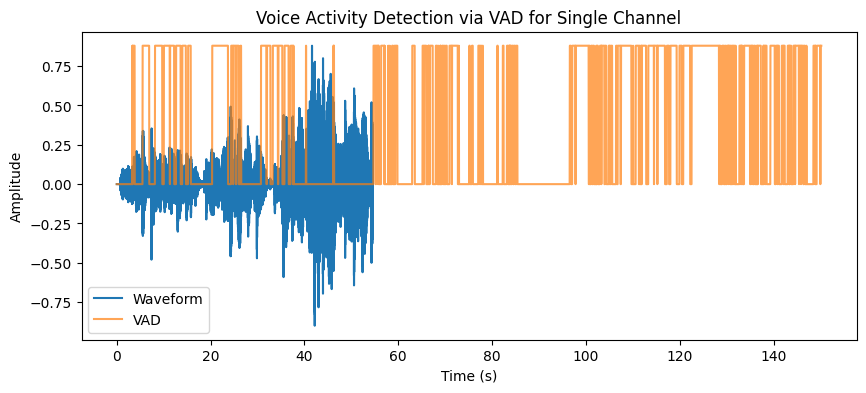

In [ ]:
# This a failed working code on how to change the indices to time

from vad.energy_vad import EnergyVAD
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

def get_energy_vad_with_time(waveform, sample_rate, num_channels):
    audio_type = {1: ["Single"],
                  2: ["Left", "Right"]}
    
    for c in range(num_channels):
        # Compute VAD using default values
        vad = EnergyVAD()
        vad_output = vad(waveform[c, :])

        # Create time array for the waveform
        time_waveform = np.arange(waveform.shape[1]) / sample_rate

        # Create time array for the VAD output
        frame_duration = 0.02  # 20ms
        time_vad = np.arange(0, len(vad_output)) * frame_duration

        # Plot VAD output and waveform
        plt.figure(figsize=(10, 4))
        plt.title(f"Voice Activity Detection via VAD for {audio_type[num_channels][c]} Channel")
        plt.plot(time_waveform, waveform[c, :], label='Waveform')
        plt.plot(time_vad, vad_output * np.max(waveform[c, :]), label='VAD', alpha=0.7)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()


get_energy_vad_with_time(waveform, sample_rate, num_channels)

In [6]:
# Extracted from copilot's recommended code

from pydub import AudioSegment
import numpy as np

def get_pydubvad(audio_file):
    audio = AudioSegment.from_file(audio_file)
    samples = np.array(audio.get_array_of_samples())
    num_channels = audio.channels
    threshold = np.mean(np.abs(samples)) * 1.5  # Adjust threshold as needed
    # threshold = 0.5

    if num_channels == 2:
        samples = samples.reshape(-1, 2)

        audio_type = {2: ["Left", "Right"]}
        
        for c in range(num_channels):
            voice_activity = np.where(np.abs(samples[:, c]) > threshold, 1, 0)
            plot_waveform_with_vad(samples[:, c], voice_activity, audio.frame_rate,
                                f"Voice Activity Detection via pydub for {audio_type[num_channels][c]} Channel")

    else:
        voice_activity = np.where(np.abs(samples) > threshold, 1, 0)
        plot_waveform_with_vad(samples, voice_activity, audio.frame_rate,
                                f"Voice Activity Detection via pydub for Single Channel")

def plot_waveform_with_vad(samples, voice_activity, sample_rate, title):
    time = np.arange(len(samples)) / sample_rate

    plt.figure(figsize=(10, 4))
    plt.plot(time, samples, label='Waveform')
    plt.plot(time, voice_activity * np.max(samples), label='VAD', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.show()


### For clip 1

Sampling Rate: 44100 Hz
Number of Samples: 2403450
Duration: 54.5 seconds


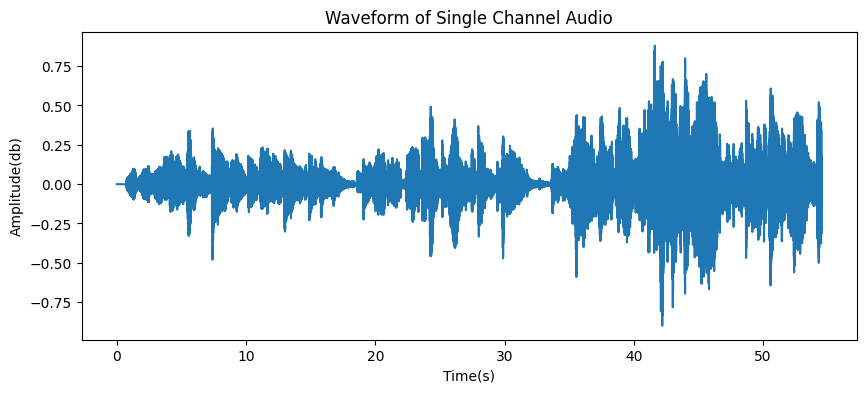

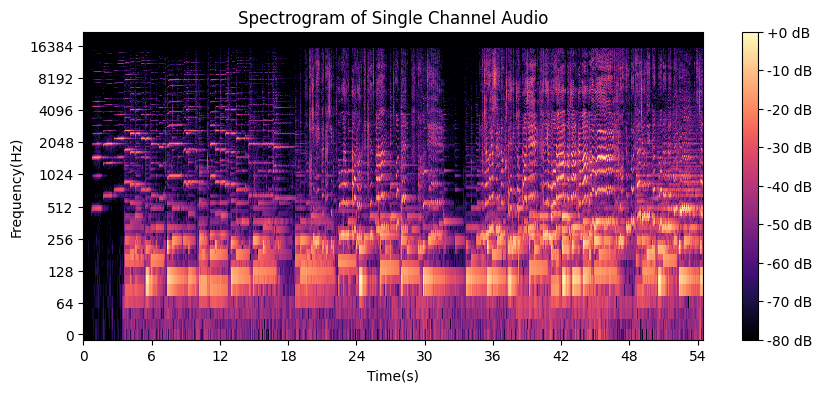

In [4]:
clip_1 = 'clip1.wav'
sample_rate, num_samples, waveform, num_channels  = extract_info(clip_1)

Number of frames to be processed: 4694


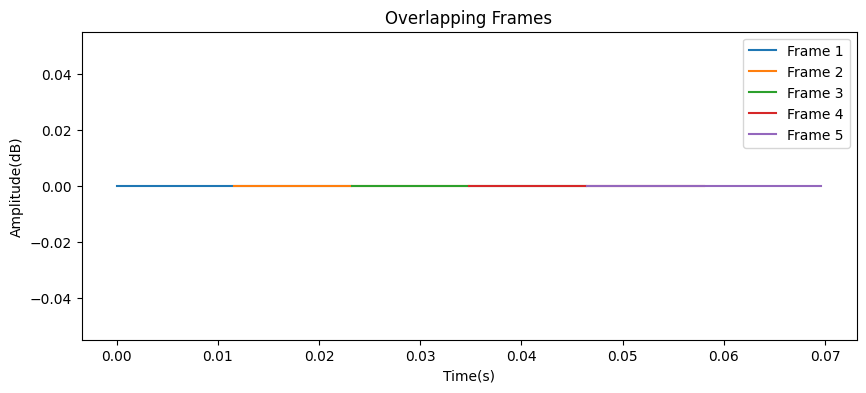

In [184]:
overlapped_frames = process_frames(waveform[0, :], sample_rate, frames_size=1024, overlap=0.5)

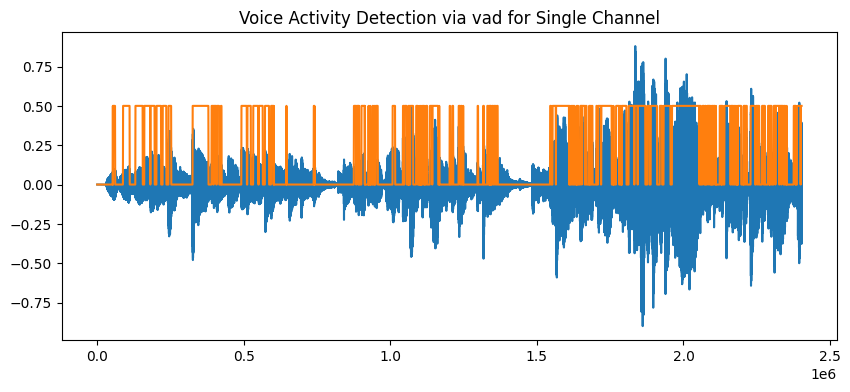

In [204]:
# Check for Voice Activity Detection (VAD)
get_energy_vad(waveform, num_channels)

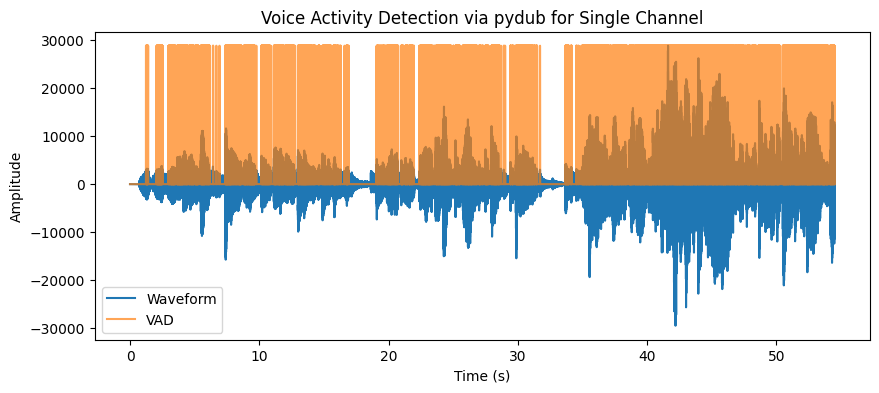

In [7]:
get_pydubvad(clip_1)

### For clip 2

Sampling Rate: 32000 Hz
Number of Samples: 144144
Duration: 4.5045 seconds


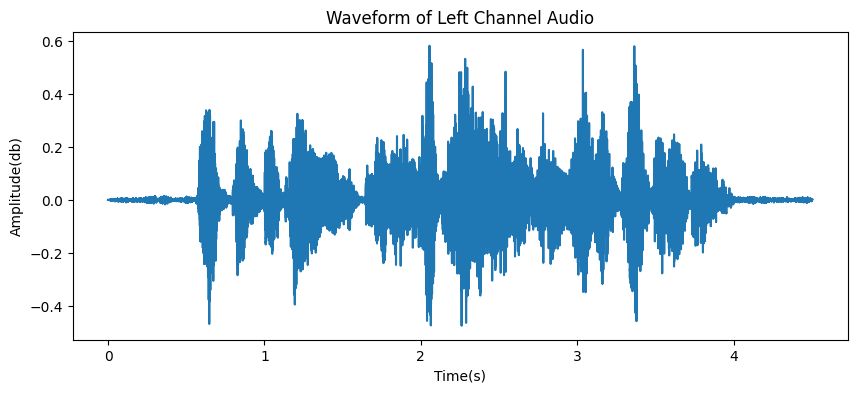

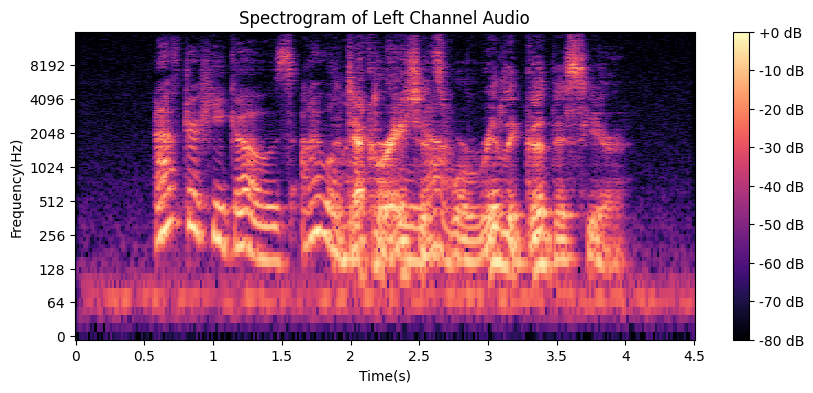

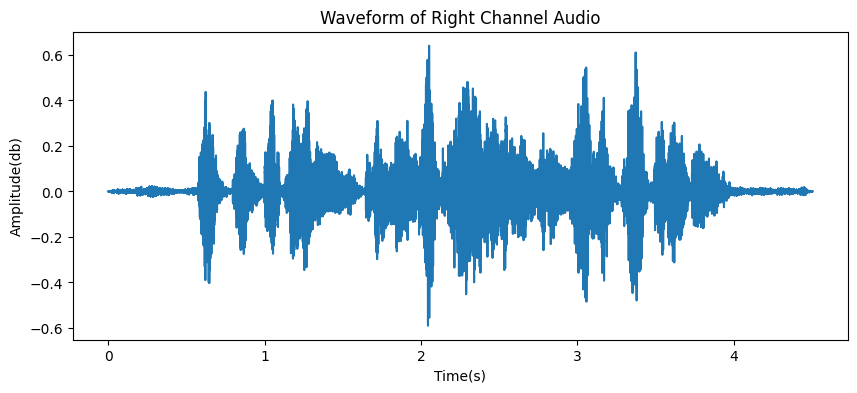

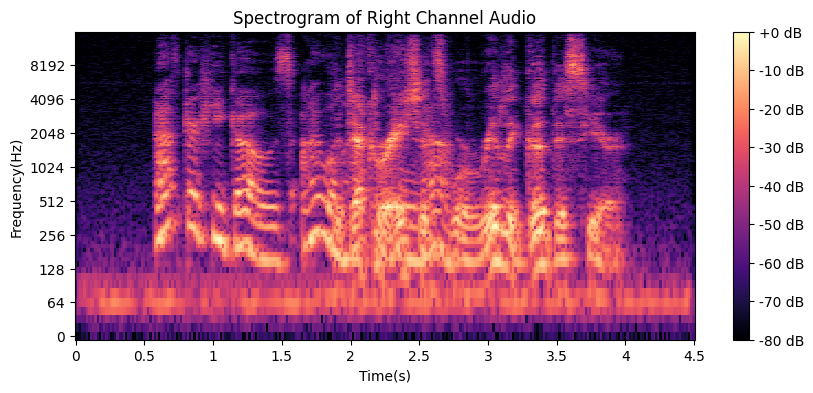

In [163]:
clip_2 = 'clip2.wav'    
sample_rate_2, num_samples_2, waveform_2, num_channels_2 = extract_info(clip_2)

Number of frames to be processed: 281


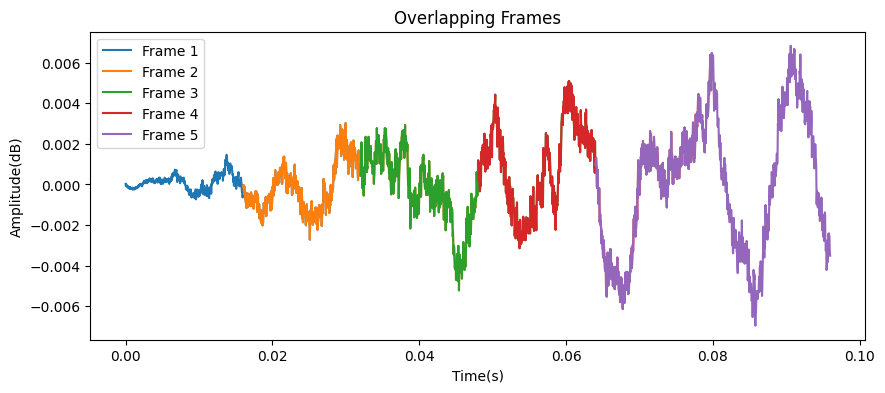

Number of frames to be processed: 281


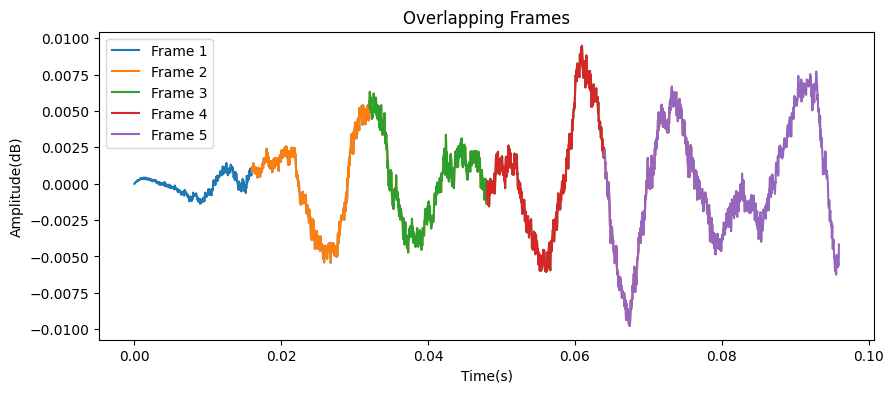

In [166]:
# Since clip 2 is stereo,
# waveform_2 = frames_data_2.reshape(-1, 2)
overlapped_frames_l = process_frames(waveform_2[0, :], sample_rate_2, frames_size=1024, overlap=0.5)
overlapped_frames_r = process_frames(waveform_2[1, :], sample_rate_2, frames_size=1024, overlap=0.5)

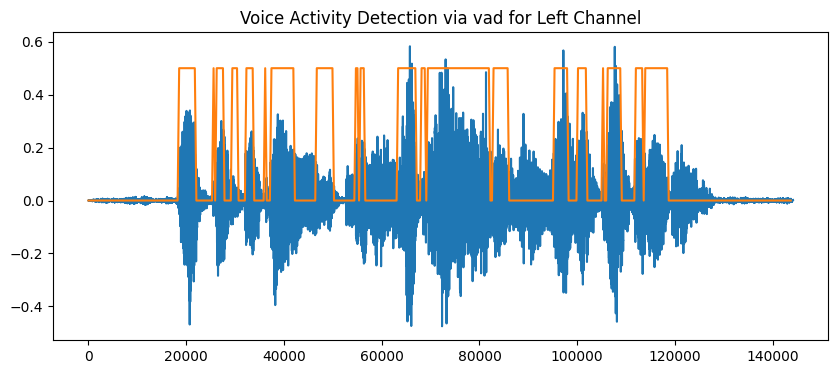

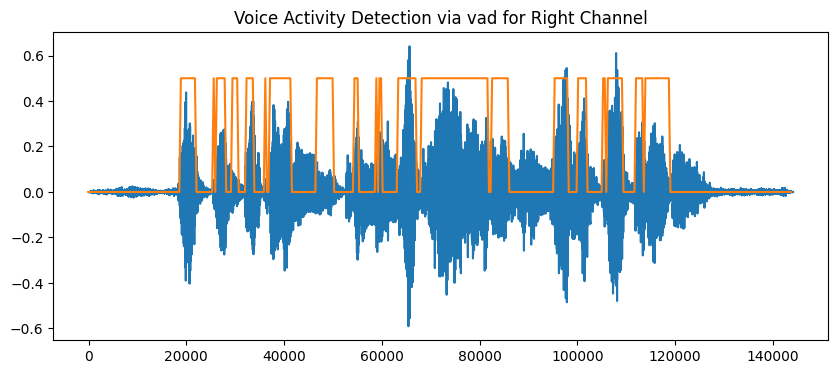

In [177]:
# Check for Voice Activity Detection (VAD)
get_energy_vad(waveform_2, num_channels_2)

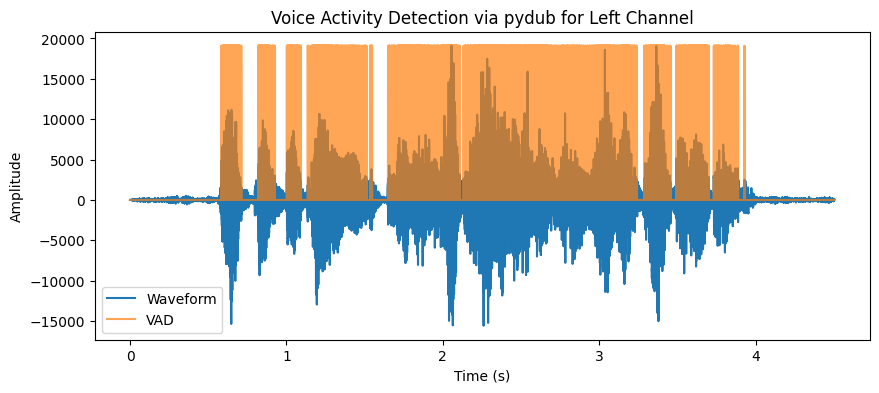

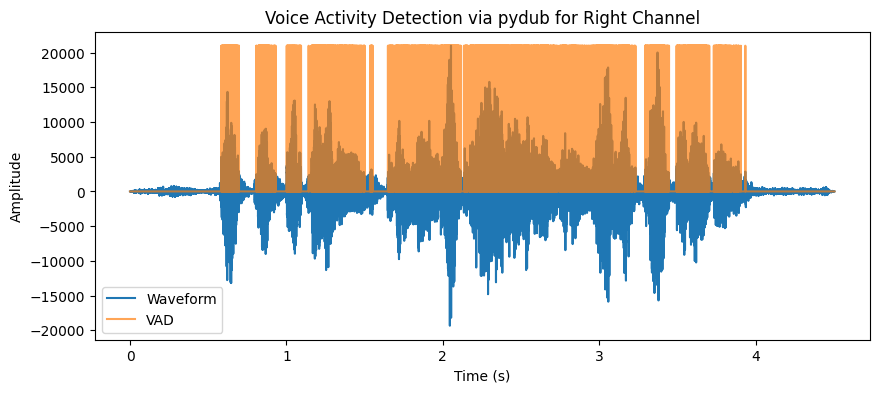

In [ ]:
get_pydubvad(clip_2)